In [1]:
import time
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from selectinf.Simulation.simulation_helpers import (one_sim_mode, one_sim_mode_serial,
                                generate_gaussian_instance_nonlinear_interaction_simple,
                                generate_gaussian_instance_nonlinear_interaction,
                                )
from selectinf.Simulation.spline_instance import (generate_gaussian_instance_from_bspline_interaction, generate_gaussian_instance_nonlinear_interaction,
 gaussian_group_polynomial_interaction_instance)
from selectinf.group_lasso_query import (group_lasso,
                                         split_group_lasso)
from selectinf.Simulation.simulation_helpers import (naive_inference_inter, data_splitting_inter,
                                MLE_inference_inter,
                                calculate_F1_score_interactions)
from selectinf.Simulation.spline_instance import (
    generate_gaussian_instance_nonlinear_interaction_block)
from multiprocessing import Pool

from functools import partial

/Users/yilingh/Desktop/PhD/SI_Codes/SI-Interaction/env3/lib/python3.9/site-packages/regreg/atoms/slope.py:16: UserWarning: unable to import isotonic regression from sklearn, using a pure python implementation
  warn('unable to import isotonic regression from sklearn, using a pure python implementation')


In [2]:
def plot_ecdf(data):
    # Step 2: Sort the data
    data_sorted = np.sort(data)
    
    # Step 3: Calculate the empirical CDF
    # For each point, the CDF value is the proportion of data points less than or equal to that point
    cdf_values = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
    
    # Step 4: Plot the empirical CDF
    plt.figure(figsize=(6, 6))
    plt.step(data_sorted, cdf_values, where='post', label='Empirical CDF')
    plt.title('Empirical Cumulative Distribution Function')
    # Add a y=x line
    plt.plot(data_sorted, data_sorted, label='Uniform CDF', linestyle='--')
    plt.xlabel('Data Points')
    plt.ylabel('CDF')
    plt.grid(True)
    plt.legend()
    plt.show()

In [3]:
s_inter = 5
p_nl = 20
gammas_list = []
targets_list = []
p_values_ll = []
const = group_lasso.gaussian

sig = 0.
(design, data_interaction, Y, Y_mean, data_combined,
 groups, active, active_inter_adj, active_inter_list, gamma) \
    = generate_gaussian_instance_nonlinear_interaction_simple(n=500,
                                                     p_nl=p_nl,
                                                     rho=0.6, full_corr=True,
                                                     rho_noise=0.6,
                                                     SNR = 0,
                                                     nknots = 6, degree = 2,
                                                     interaction_signal=sig,
                                                     random_signs=False,
                                                     scale=True,
                                                     center=True,structure='weakhierarchy',
                                                     s_interaction=s_inter,
                                                     intercept=True,
                                                     return_gamma=True)

Equally spaced quantile knots used.


In [4]:
const = group_lasso.gaussian
coverages, lengths, selected_inter, p_values, gamma \
    = naive_inference_inter(X=design, Y=Y, groups=groups,
                            Y_mean=Y_mean, const=const,
                            n_features=p_nl, interactions=data_interaction,
                            weight_frac=0.5, level=0.9, mode='weakhierarchy',
                            solve_only=False, continued=False,
                            parallel=False, p_val=True, intercept=True)

[1, 8, 9, 10, 11, 15, 16, 17, 20]
9.0
Naive Selection Size: 4


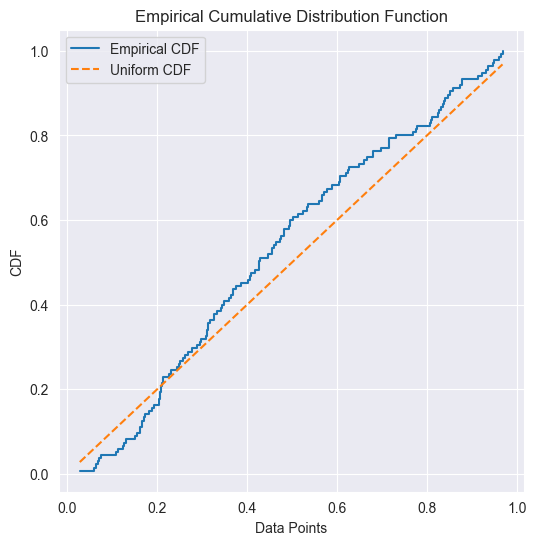

In [5]:
plot_ecdf(p_values)

In [6]:
np.mean(coverages)

0.9703703703703703

In [58]:
oper_char = {}
oper_char["coverage rate"] = []
oper_char["avg length"] = []
oper_char["method"] = []
oper_char["rho"] = []
oper_char["target"] = []
oper_char["pval"] = []
const = group_lasso.gaussian
active_inter_list = np.array([[0,1], [1,2], [2,4], [1,5], [2,6]])

#p = 50
#rho = 0.5
sig = 0.
weights = 0.5
s_inter = 5
p_nl = 20

for i in range(500):
    for rho in [0.25, 0.5, 0.75]:
        while True:
            (design, data_interaction, Y, Y_mean, data_combined,
             groups, active, active_inter_adj, active_inter_list, gamma) \
                = (generate_gaussian_instance_nonlinear_interaction_simple
                   (n=200, p_nl=p_nl, rho=rho, full_corr=False, rho_noise=rho,
                    SNR = 0, nknots = 6, degree = 2, interaction_signal=sig,
                    random_signs=False, scale=True, center=False,
                    structure='weakhierarchy', s_interaction=s_inter, intercept=True,
                    active_inter_list=active_inter_list, return_gamma=True))
        
            coverages, lengths, selected_inter, p_values, targets \
                = naive_inference_inter(X=design, Y=Y, groups=groups,
                                        Y_mean=Y_mean, const=const,
                                        n_features=20, interactions=data_interaction,
                                        weight_frac=weights, level=0.9, mode='allpairs',
                                        solve_only=False, continued=False,
                                        parallel=False, p_val=True, 
                                        return_pivot=True, intercept=True, 
                                        target_ids=[(0,1)])
            
            noselection = coverages is None
                
            if not noselection:

                coverages_ds, lengths_ds, selected_inter_ds, p_values_ds, targets_ds \
                    = data_splitting_inter(X=design, Y=Y, groups=groups,
                                   Y_mean=Y_mean, const=const,
                                   n_features=20, interactions=data_interaction,
                                   proportion=0.5,
                                   weight_frac=weights, level=0.9, mode='allpairs',
                                   solve_only=False, continued=False, parallel=False,
                                   p_val=True, target_ids=[(0,1)])
                noselection = coverages_ds is None
                        
            if not noselection:
                coverages_MLE, lengths_MLE, selected_inter_MLE, p_values_MLE, targets_MLE\
                    = (MLE_inference_inter
                       (X=design, Y=Y, Y_mean=Y_mean, groups=groups,
                        n_features=p_nl, interactions=data_interaction,
                        intercept=True, proportion=0.5, weight_frac=weights,
                        level=0.9, mode='allpairs', solve_only=False, 
                        continued=False, parallel=False, p_val=True, 
                        target_ids=[(0,1)]))
                noselection = coverages_MLE is None
            
            if not noselection:
                # Naive
                oper_char["coverage rate"].append(np.mean(coverages))
                oper_char["avg length"].append(np.mean(lengths))
                oper_char["method"].append('Naive')
                oper_char["rho"].append(rho)
                oper_char["target"].append(targets[0])
                oper_char["pval"].append(p_values[0])
    
                # Data splitting
                oper_char["coverage rate"].append(np.mean(coverages_ds))
                oper_char["avg length"].append(np.mean(lengths_ds))
                oper_char["method"].append('Data Splitting')
                oper_char["rho"].append(rho)
                oper_char["target"].append(targets_ds[0])
                oper_char["pval"].append(p_values_ds[0])
                
                # MLE
                oper_char["coverage rate"].append(np.mean(coverages_MLE))
                oper_char["avg length"].append(np.mean(lengths_MLE))
                oper_char["method"].append('MLE')
                oper_char["rho"].append(rho)
                oper_char["target"].append(targets_MLE[0])
                oper_char["pval"].append(p_values_MLE[0])
                
                break

Equally spaced quantile knots used.
[0, 2, 5, 11, 13, 14, 15, 18, 20]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [56]:
def plot_ecdf_by_method(values, labels, rho_list):
    values = np.array(values)
    labels = np.array(labels)
    rho_list = np.array(rho_list)
    # Function to calculate ECDF
    def ecdf(data):
        x = np.sort(data)
        n = x.size
        y = np.arange(1, n+1) / n
        return x, y
    
    my_palette = {"MLE": "#48c072", 
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}
    
    # Create a 2x2 subplot grid
    fig, axes = plt.subplots(nrows=1, ncols=len(list(np.unique(rho_list))), 
                             figsize=(5*len(list(np.unique(rho_list))), 5))
    if len(list(np.unique(rho_list))) > 1:
        axes_list = axes.flatten()
    else:
        axes_list = [axes]
    i = 0
    for ax in axes_list:
        rho = np.unique(rho_list)[i]
        values_i = values[rho_list == rho]
        labels_i = labels[rho_list == rho]
    
        # Create a DataFrame
        df = pd.DataFrame({'Values': values_i, 'Distribution': labels_i})

        # Plotting
        for distribution in df['Distribution'].unique():
            x, y = ecdf(df[df['Distribution'] == distribution]['Values'])
            ax.plot(x, y, marker='.', linestyle='none', label=distribution,
                    color=my_palette[distribution])
    
        # Add y = x line
        ax.plot([0, 1], [0, 1], 'k--', label='y = x')

        ax.set_title('$rho=$'+str(rho))
        ax.set_xlabel('Value')
        ax.set_ylabel('ECDF')
        ax.axis(xmin=0.,xmax=1, ymin=0., ymax=1)
        ax.legend()
        ax.grid(True)
        i += 1
    # Adjust layout to prevent overlap
    plt.tight_layout()
    #plt.legend(handles, labels, loc='lower center', ncol=4)
    plt.show()

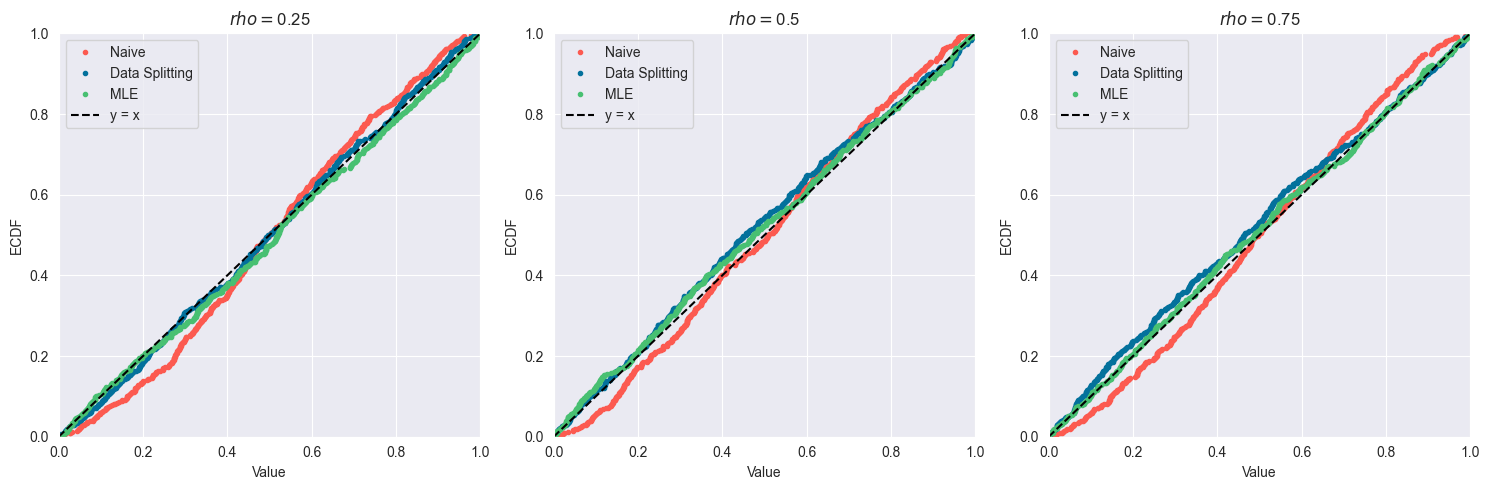

In [57]:
plot_ecdf_by_method(values=oper_char["pval"], labels=oper_char["method"],
                    rho_list=oper_char["rho"])

In [14]:
coverages_ds, lengths_ds, selected_inter_ds, p_values_ds \
    = data_splitting_inter(X=design, Y=Y, groups=groups,
                           Y_mean=Y_mean, const=const,
                           n_features=p_nl, interactions=data_interaction,
                           proportion=0.5,
                           weight_frac=0.5, level=0.9, mode='weakhierarchy',
                           solve_only=False, continued=False, parallel=False,
                           p_val=True)


9.0
DS Selection Size: 4


ValueError: too many values to unpack (expected 4)

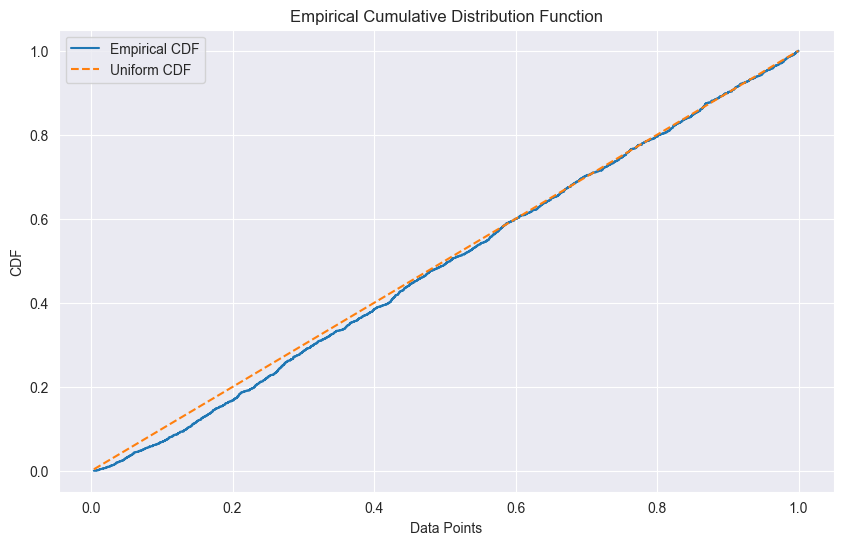

In [116]:
plot_ecdf(p_values_ds)

In [66]:
np.mean(lengths_ds)

8.019015947836863

In [14]:
coverages_MLE, lengths_MLE, selected_inter_MLE, p_values_MLE\
    = MLE_inference_inter(X=design, Y=Y, Y_mean=Y_mean, groups=groups,
                           n_features=100, interactions=data_interaction,
                          intercept=False,
                           proportion=0.5, weight_frac=10, level=0.9, mode='weakhierarchy',
                           solve_only=False, continued=False, parallel=False,
                           p_val=True)

LinAlgError: Singular matrix

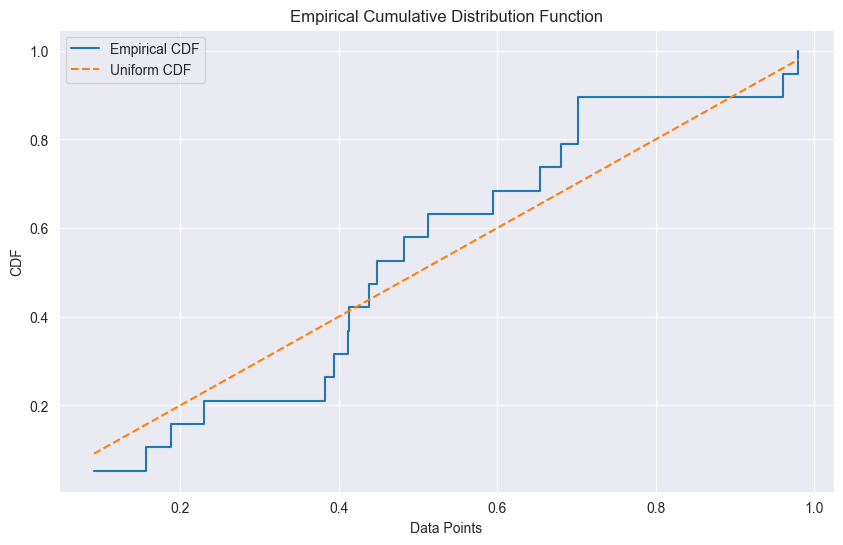

0.9473684210526315


In [77]:
plot_ecdf(p_values_MLE)
print(np.mean(coverages_MLE))

In [78]:
np.mean(lengths_MLE)

3.554918650077396